In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import scipy.io.wavfile
import scipy.signal
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt
import zipfile
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !pip install --upgrade mne

# Data Pre-Processing

In [ ]:
# Denoising
def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform')
        clf.fit(df_denoised.index.values[:, np.newaxis], df_denoised[col_name])
        y_pred = clf.predict(df_denoised.index.values[:, np.newaxis])
        df_denoised[col_name] = y_pred
        # ax = pd.Series(df[col_name]).plot(color='lightgray')
        # # pd.Series(df["events"]).plot(color='g', ax=ax)
        # pd.Series(y_pred).plot(color='black', ax=ax, figsize=(12, 8))
        # plt.title("Denoising data")

    return df_denoised

# Z_scoring
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()

    return df_standard

# Detrending
def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended

    return df_detrended

# Band-pass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def Extract_channel_FreqBands(df):
    channels = df.columns.to_list()
    fs = 250  # Sampling rate
    bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 40)}
    df_new = pd.DataFrame()

    for channel in channels:

        # Filter signal in frequency band of interest
        for i in bands:
            f_low = bands[i][0];
            f_high = bands[i][1];
            x_filt = butter_bandpass_filter(df[channel], f_low, f_high, fs)
            df_new[channel + '_' + i] = x_filt

    return df_new

# Applying the preprocessing functions and concatinating the dataframes
def read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=False):
    fs=250
    eeg_files = glob.glob(os.path.join(path, "eeg/*eeg.csv"))
    event_files = glob.glob(os.path.join(path, "event/*event.csv"))

    eeg_files = sorted(eeg_files)
    event_files = sorted(event_files)

    if FreqBands:
        df = pd.DataFrame(columns=['P3_t_delta', 'P3_t_theta', 'P3_t_alpha', 'P3_t_beta', 'P3_t_gamma',
                                   'C3_t_delta', 'C3_t_theta', 'C3_t_alpha', 'C3_t_beta', 'C3_t_gamma',
                                   'C4_t_delta', 'C4_t_theta', 'C4_t_alpha', 'C4_t_beta', 'C4_t_gamma',
                                   'F5_t_delta', 'F5_t_theta', 'F5_t_alpha', 'F5_t_beta', 'F5_t_gamma',
                                   'P3_e_delta', 'P3_e_theta', 'P3_e_alpha', 'P3_e_beta', 'P3_e_gamma',
                                   'C3_e_delta', 'C3_e_theta', 'C3_e_alpha', 'C3_e_beta', 'C3_e_gamma',
                                   'C4_e_delta', 'C4_e_theta', 'C4_e_alpha', 'C4_e_beta', 'C4_e_gamma',
                                   'F5_e_delta', 'F5_e_theta', 'F5_e_alpha', 'F5_e_beta', 'F5_e_gamma',
                                   'events'])

    else:
        df = pd.DataFrame(columns=['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e', 'events'])

    # loop over the list of csv files
    for eeg, event in zip(eeg_files, event_files):

        # read the csv file
        eeg_df = pd.read_csv(eeg)
        event_df = pd.read_csv(event)

        # Remove spaces
        eeg_df.columns = eeg_df.columns.str.replace(' ', '')

        # Select useful columns
        eeg_df = eeg_df[["FZ", "FC1", "FC2", "C3", "CZ", "C4", "CPZ", "PZ"]]

        # Rename columns
        eeg_df.columns = ['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e']

        # Bandpass filter on raw data
        for column in eeg_df.columns:
            # eeg_df[column] = butter_bandpass_filter(eeg_df[column], lowcut=.5, highcut=40, fs=250)
            b, a = butter(2, [0.5/(fs/2), 80/(fs/2)], btype='bandpass')  # 4th order bandpass filter coefficients
            eeg_df[column] = filtfilt(b, a, eeg_df[column])  # Apply bandpass filter

        # Extract FreqBands
        if FreqBands:
            eeg_df = Extract_channel_FreqBands(eeg_df)



        #Z-score
        eeg_df = z_score(eeg_df, list(eeg_df.columns))

        # Detrending
        eeg_df = detrend(eeg_df, list(eeg_df.columns))

        # Denoising
        eeg_df = denoise_data(eeg_df, list(eeg_df.columns), n_clusters=[80]*len(eeg_df.columns))


        # Concat
        df_concat = pd.concat([eeg_df, event_df], axis=1)

        # Remove Nan rows
        df_concat = df_concat.dropna(axis=0)

        # Remove rows with glass_event == 0 (because actually we don't need them)
        df_concat = df_concat[df_concat.glass_event != 0].reset_index()

        # Select usefull columns
        df_concat = df_concat[list(df.columns)]

        # Remove unselected events
        for i in range(3):
            if i not in events:
                df_concat = df_concat[df_concat.events != i]

        df = df.append(df_concat)

    df = df.reset_index()
    df = df.drop('index', axis=1)

    return df

In [ ]:
# Read and Prepare Data
path = "/content/drive/My Drive/Colab Notebooks/VBGdata/EEGdata_Tripolar/subject1/task_3"
df = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=False)
# df_bands = read_data_and_preprocessing(path, events=[0, 1, 2], FreqBands=True)
# Seperate the inputs and labels
# labels = df["events"].to_list()
# df.drop(['events'], axis=1, inplace=True)
# df_eeg = df[['P3_e', 'C3_e', 'C4_e', 'F5_e']]
# df_tripolar = df[['P3_t', 'C3_t', 'C4_t', 'F5_t']]

In [ ]:
df.head()

,P3_t,C3_t,C4_t,F5_t,P3_e,C3_e,C4_e,F5_e,events
0,-9.87825,-9.696385,-9.755805,-6.548688,-9.643982,-10.126001,-9.658483,-9.664417,0
1,-9.87825,-9.696385,-9.755805,-6.548688,-9.643982,-10.126001,-9.658483,-9.664417,0
2,-9.87825,-9.696385,-9.755805,-6.548688,-9.643982,-10.126001,-9.658483,-9.664417,0
3,-9.87825,-9.696385,-9.755805,-6.548688,-9.643982,-10.126001,-9.658483,-9.664417,0
4,-9.87825,-9.696385,-9.755805,-6.548688,-9.643982,-10.126001,-9.658483,-9.664417,0


In [ ]:

# path = "/content/drive/My Drive/Colab Notebooks/VBGdata/EEGdata_Tripolar/subject2/task_3/eeg/20230424_134434_eeg.csv"
# df2 = df = pd.read_csv(path)
# df2= df2.iloc[:,:8]
# df2.columns = ['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e']
# for column in df2.columns:
#     df2[column] = butter_bandpass_filter(df2[column], lowcut=.5, highcut=40, fs=250)

# df2.head()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df2.plot(subplots=True,
#         layout=(4, 2),
#         figsize=(14,10),
#         fontsize=12,
#         linewidth=2,
#         sharex=True, #
#         sharey=True,
#         title='Visualization of the original Time Series',
#         grid=True,
#         ylabel='Amplitude',
#         xlabel='Samples')
# plt.xlabel('Samples', fontsize=14)
# plt.ylabel('Samples', fontsize=14)

# plt.show()

# time domain features

In [ ]:
def Extract_Instance(data, target_event, instance_num):
  window_size = 1501;
  fs=250;
  cnt = 0
  for i in range(0, len(data), window_size):
    x = data.iloc[i:i+window_size]
    if x['events'].iloc[0] == target_event:
      cnt+=1
      if cnt == instance_num:
        instance_data = x
        # print('found it', cnt, i)
  return instance_data

In [ ]:
import scipy
from scipy import signal, stats

def extract_time_domain_features(data, target_channel, target_event, instance_num):
  data_target = Extract_Instance(data , target_event, instance_num)
  data_target = data_target[target_channel]
  fs = 250
  mean = np.mean(data_target)
  variance = np.var(data_target)
  skewness = stats.skew(data_target)
  kurtosis = stats.kurtosis(data_target)
  zero_crossings = np.where(np.diff(np.signbit(data_target)))[0]
  zero_crossing_rate = len(zero_crossings) / (len(data_target) / fs)
  waveform_length = np.sum(np.abs(np.diff(data_target)))
  root_mean_square = np.sqrt(np.mean(np.square(data_target)))
  peak_to_peak_amplitude = np.max(data_target) - np.min(data_target)
  crest_factor = np.max(np.abs(data_target)) / root_mean_square
  impulse_factor = np.max(np.abs(data_target)) / np.sqrt(np.mean(np.square(data_target)))
  margin_factor = (np.max(np.abs(data_target)) - root_mean_square) / root_mean_square
  shape_factor = root_mean_square / np.mean(np.abs(data_target))

  # Return features as dictionary
  features = {
        "mean": mean,
        "variance": variance,
        "skewness": skewness,
        "kurtosis": kurtosis,
        "zero_crossing_rate": zero_crossing_rate,
        "waveform_length": waveform_length,
        "root_mean_square": root_mean_square,
        "peak_to_peak_amplitude": peak_to_peak_amplitude,
        "crest_factor": crest_factor,
        "impulse_factor": impulse_factor,
        "margin_factor": margin_factor,
        "shape_factor": shape_factor,
    }
  print(features)

  return features

In [ ]:
features = extract_time_domain_features(data = df, target_channel = 'C3_t', target_event = 1, instance_num = 5)

{'mean': 0.005971117885884042, 'variance': 0.2384420385950665, 'skewness': -0.35252389603193035, 'kurtosis': 0.17791211934208162, 'zero_crossing_rate': 3.164556962025317, 'waveform_length': 23.08810278178182, 'root_mean_square': 0.48834177872047113, 'peak_to_peak_amplitude': 2.5722909524432946, 'crest_factor': 2.7288952321884463, 'impulse_factor': 2.7288952321884463, 'margin_factor': 1.728895232188446, 'shape_factor': 1.2771315429366525}


#Evoked Related Potentials (ERP)

In [ ]:
def extract_trialERP(data, target_channel, epoch_size, target_event, instance_num):
  window_size = 1501;
  fs=250
  data_target = Extract_Instance(data , target_event, instance_num)
  data_target = data_target[target_channel]

  erp_list=[]; time_list=[]; f_list=[]; Pxx_mean_list=[]
  for n in range(0, len(data_target), epoch_size):
    epoch_signal = data_target.iloc[n:n+epoch_size]
    erp = np.mean(epoch_signal)
    time = (n*epoch_size)/(1*fs)
    time_list.append(time)
    erp_list.append(erp)
  return np.array(erp_list), np.array(time_list)

In [ ]:
erp_list, time_list = extract_trialERP(data = df, target_channel = 'C3_t', epoch_size =10, target_event = 2, instance_num = 5)

## average of ERP signals of all trials

In [ ]:
def Cal_avgERP(data, target_channel, epoch_size, target_event):
  index = data.index[data['events'].shift() != data['events']].tolist()
  event_num = [x for x in index if data['events'][x]==target_event]
  window_size = 1501;
  fs=250
  erp_list_all=[];
  nn=len(event_num)
  if target_event == 0:
    nn= nn+int(nn/2)
  for n in range(1,nn):
    data_target = Extract_Instance(data , target_event, n)
    data_target = data_target[target_channel]
    erp_list=[]; time_list=[];
    # for n in range(0, len(data_target), epoch_size):
    cnt = len(data_target)//epoch_size;
    for n in range(cnt):
      # epoch_signal = data_target.iloc[n:n+epoch_size]
      epoch_signal = data_target.iloc[n*epoch_size: (n+1)*epoch_size]
      erp = np.mean(epoch_signal)
      time = (n*epoch_size)/(1*fs)
      time_list.append(time)
      erp_list.append(erp)
    erp_list_all.append(np.array(erp_list))
  return np.array(erp_list_all), np.array(time_list)

In [ ]:
def plot_ERPavg(data, epoch_size):
  fig, ax = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=(14,7))
  linewidth= 2.5
  font = 13
  events = ['empty event', 'Bottle event', 'Pen event']
  fig.suptitle('Average Event-Related Potential of empty (left), Bottle (middle) and pen (right) events', fontsize=font+2)

  for target_event in [0, 1, 2]:
    for target_channel in ['P3_t', 'C3_t', 'C4_t', 'F5_t']:
      erp_list_all , time_list= Cal_avgERP(data, target_channel, epoch_size, target_event)
      ax[0, target_event].plot(time_list, np.mean(erp_list_all, axis=0), linewidth= linewidth)
      ax[0, target_event].grid(True)
      # ax[0, target_event].set_xticklabels(time_list, fontsize=font)

    for target_channel in ['P3_e', 'C3_e', 'C4_e', 'F5_e']:
      erp_list_all , time_list= Cal_avgERP(data, target_channel, epoch_size, target_event)
      ax[1, target_event].plot(time_list, np.mean(erp_list_all, axis=0), linewidth=linewidth)
      ax[1, target_event].grid(True)
      ax[1, target_event].set_xlabel('Time(S)', fontsize = font);
      # ax[1, target_event].set_xticklabels(time_list, fontsize=font)

  ax[0,2].legend(['P3_t', 'C3_t', 'C4_t', 'F5_t'], loc = 'lower right')
  ax[0,0].set_ylabel('Amplitude', fontsize = font);
  # ax[0, 0].set_yticklabels(erp_list_all, fontsize=font+2)

  ax[1,0].set_ylabel('Amplitude', fontsize = font);
  ax[1,2].legend(['P3_e', 'C3_e', 'C4_e', 'F5_e'], loc = 'lower right')
  ax[1,0].set_xlabel('Time(S)', fontsize = font);
  # ax[1, 0].set_yticklabels(erp_list_all, fontsize=font+2)

  plt.show()

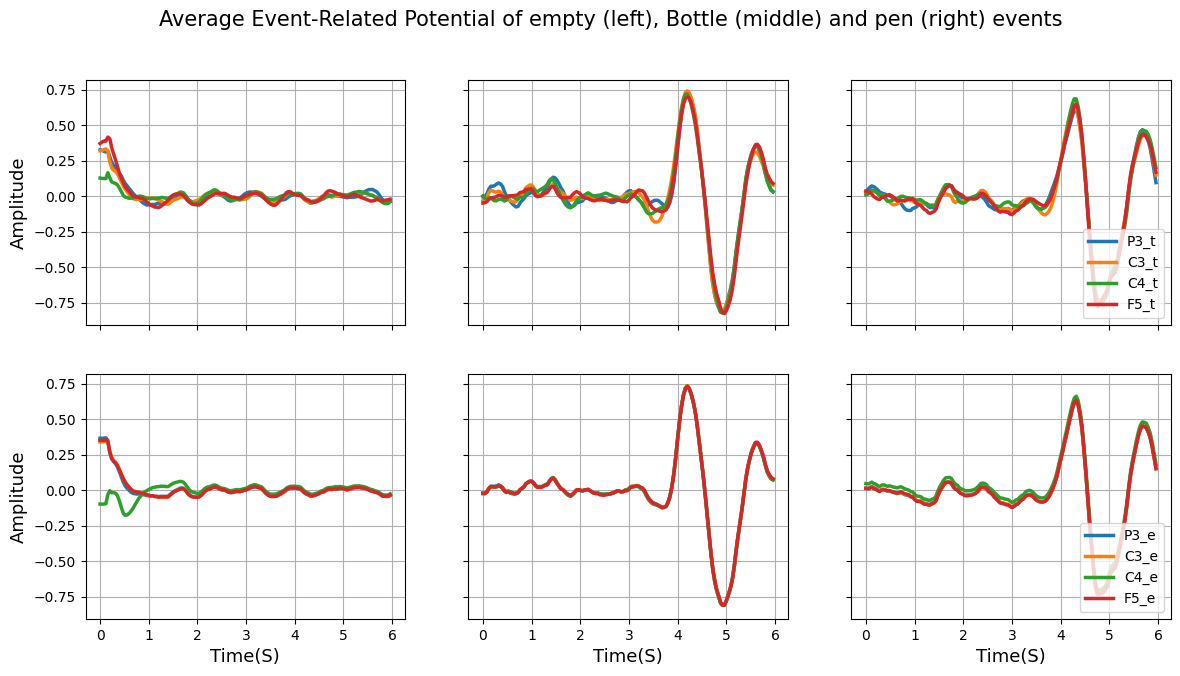

In [ ]:
plot_ERPavg(df, 10)

## Periodogram

In [ ]:
from scipy.signal import welch, periodogram, find_peaks
from scipy import signal

def extract_PSD(data, target_channel, target_event, instance_num):
  fs = 250
  data_target = Extract_Instance(data, target_event, instance_num)
  data_target = data_target[target_channel]
  # f, px = periodogram(np.array(data_target), fs)
  f, psd = welch(np.array(data_target), fs, nperseg=fs*2)
  peaks, _ = find_peaks(psd, height=0)

  return  f, psd, peaks

In [ ]:
def plot_PSD(data, target_event, instance_num):
  fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, sharex=True, figsize=(20,4))
  linewidth = 2.5
  events = ['empty event', 'Bottle event', 'Pen event']
  for target_channel in ['P3_t', 'C3_t', 'C4_t', 'F5_t']:#
    f, px, peaks = extract_PSD(data, target_channel, target_event, instance_num)
    ax[0].semilogy(f, px, linewidth=linewidth);
    # ax[0].semilogx(f[peaks], px[peaks], 'x', label='peaks')

  for target_channel in ['P3_e', 'C3_e', 'C4_e', 'F5_e']:#
    f, px, peaks = extract_PSD(data, target_channel, target_event, instance_num)

    ax[1].semilogy(f, px, linewidth=linewidth);
    # ax[1].semilogx(f[peaks], px[peaks], 'x', label='peaks')

  font = 12
  fig.suptitle('Periodogram of the ' + events[target_event], fontsize=font+2)
  ax[0].legend(['P3_t', 'C3_t', 'C4_t', 'F5_t'], loc = 'lower right')
  ax[0].grid()
  ax[0].set_ylabel('Power Spectral Density (dB)', fontsize = font);
  ax[0].set_xlabel('Frequency (Hz)', fontsize = font);
  ax[1].legend(['P3_e', 'C3_e', 'C4_e', 'F5_e'], loc = 'lower right')
  ax[1].grid()
  ax[1].set_xlabel('Frequency (Hz)', fontsize = font);
  plt.show()

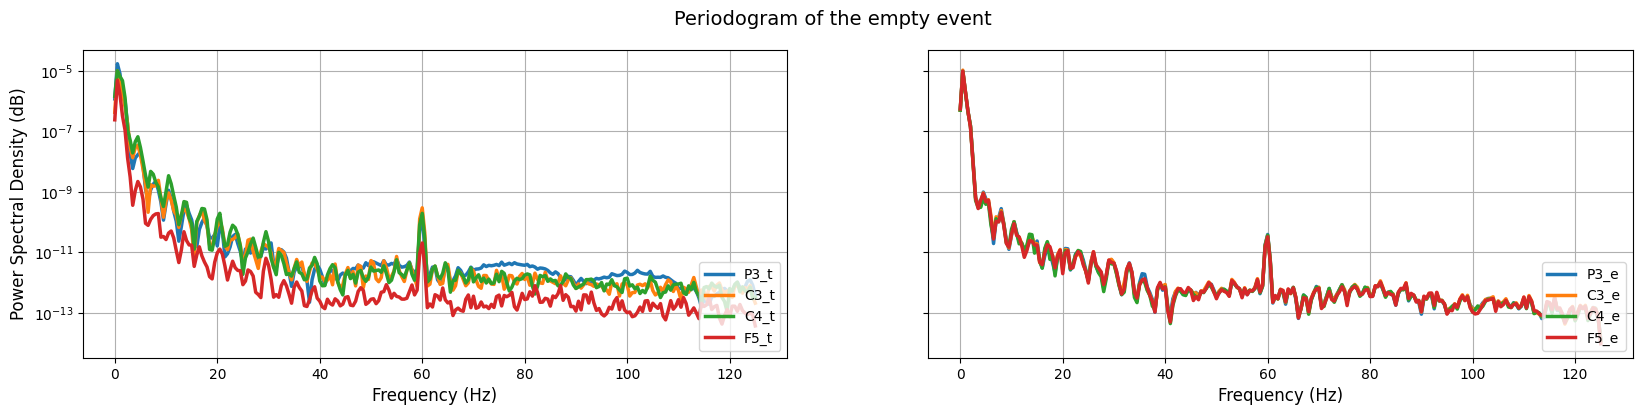

In [ ]:
plot_PSD(data = df.copy(), target_event = 0, instance_num=3)

In [ ]:
def plot_PSD2(data, instance_num):
  fig, ax = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=(14,7))
  linewidth= 2.5
  font = 13
  events = ['empty event', 'Bottle event', 'Pen event']
  fig.suptitle('Periodogram of empty (left), Bottle (middle) and pen (right) events', fontsize=font+2)

  for target_event in [0,1,2]:
    for target_channel in ['P3_t', 'C3_t', 'C4_t', 'F5_t']:
      f, px, peaks = extract_PSD(data, target_channel, target_event, instance_num)
      ax[0, target_event].semilogy(f, px, linewidth = linewidth);
      ax[0, target_event].grid(True)

    for target_channel in ['P3_e', 'C3_e', 'C4_e', 'F5_e']:
      f, px, peaks = extract_PSD(data, target_channel, target_event, instance_num)
      ax[1, target_event].semilogy(f, px, linewidth = linewidth);
      ax[1, target_event].grid(True)
      ax[1, target_event].set_xlabel('Frequency (Hz)', fontsize = font);

  ax[0,2].legend(['P3_t', 'C3_t', 'C4_t', 'F5_t'], loc = 'lower right')
  ax[0,0].set_ylabel('Power Spectral Density (dB)', fontsize = font);

  ax[1,0].set_ylabel('Power Spectral Density (dB)', fontsize = font);
  ax[1,2].legend(['P3_e', 'C3_e', 'C4_e', 'F5_e'], loc = 'lower right')
  ax[1,0].set_xlabel('Frequency (Hz)', fontsize = font);

  plt.show()

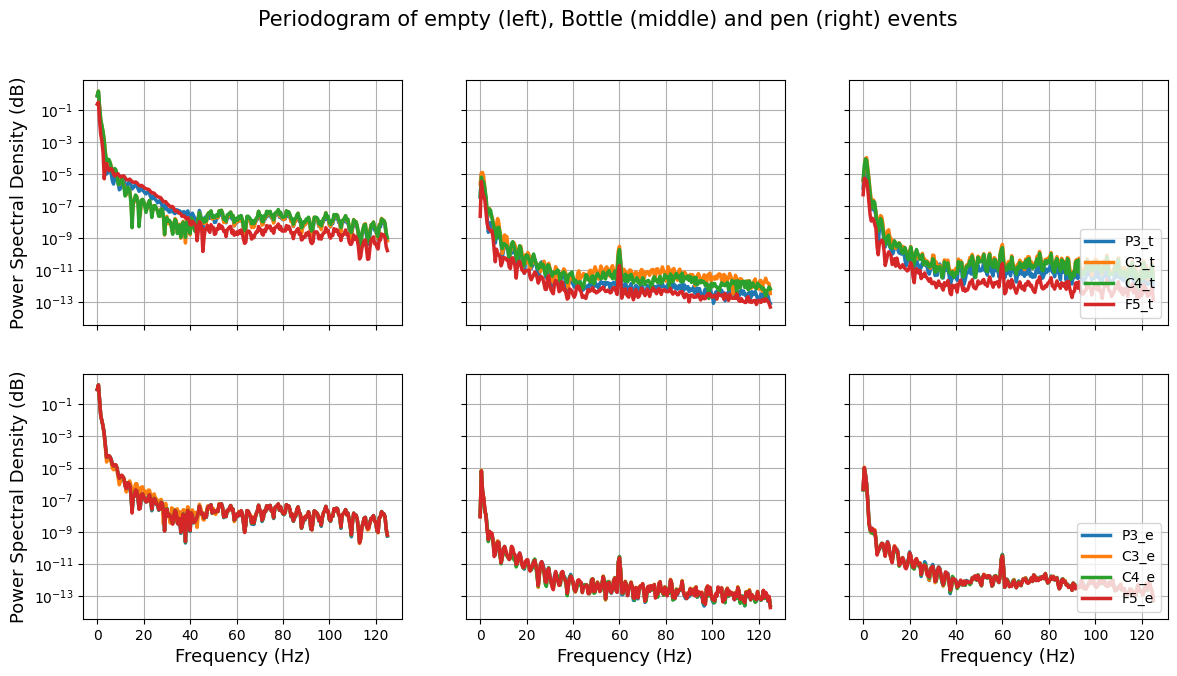

In [ ]:
plot_PSD2(df, 1)

In [ ]:
def plot_avgPSD(data, target_event, instance_num):
  for target_channel in ['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e']:
    for
    f, px, peaks = extract_PSD(data, target_channel, target_event, instance_num)



## extracting features from PSD

In [ ]:
from scipy.integrate import simps #compute the area under the curve of the PSD within a specific frequency band,
def Extract_PSD_features(data, target_channel1, target_channel2, target_event, instance_num):
  fs = 250
  data_target = Extract_Instance(data, target_event, instance_num)
  data_target1 = data_target[target_channel1]

  # freq bands
  bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'gamma': (30, 40)}

  f, psd = signal.welch(data_target1, fs=fs, nperseg=fs*2)

  # absolute and relative power for each band
  power = {}
  for band, (fmin, fmax) in bands.items():
    idx = np.logical_and(f >= fmin, f <= fmax)
    power[band] = simps(psd[idx], f[idx])
  total_power = simps(psd, f)
  relative_power = {band: (p / total_power) * 100 for band, p in power.items()}

  # Compute peak frequency for each band
  peak_freq = {band: f[np.argmax(psd[idx])] for band, (fmin, fmax) in bands.items()}

  # spectral edge frequency at 95%
  cdf = np.cumsum(psd) / total_power
  sef95 = f[np.argmax(cdf >= 0.95)]

  # spectral entropy using Shannon entropy
  entropy = -np.sum(psd * np.log2(psd)) / total_power

  #coherence between two EEG signals
  data_target2 = data_target[target_channel2]
  f, coh = signal.coherence(data_target1, data_target2, fs=fs, nperseg=fs*2)
  mean_coh = np.mean(coh)

  print('Absolute power:', power)
  print('Relative power:', relative_power)
  print('Peak frequency:', peak_freq)
  print('SEF95:', sef95)
  print('Spectral entropy:', entropy)
  print('Mean coherence:', mean_coh)

In [ ]:
Extract_PSD_features(data =df, target_channel1 = 'C3_t', target_channel2 = 'C4_t', target_event = 1, instance_num = 2)

Absolute power: {'delta': 0.15008194623474874, 'theta': 0.0016520638872567965, 'alpha': 0.00013473853465965097, 'beta': 7.174899646293848e-05, 'gamma': 2.478906613844144e-06}
Relative power: {'delta': 56.61923655540303, 'theta': 0.6232501535589368, 'alpha': 0.0508308504681214, 'beta': 0.027067702047212126, 'gamma': 0.0009351811026521612}
Peak frequency: {'delta': 3.0, 'theta': 3.0, 'alpha': 3.0, 'beta': 3.0, 'gamma': 3.0}
SEF95: 1.0
Spectral entropy: 6.509181815514015
Mean coherence: 0.22916100417399923


## Wavelet analysis

In [ ]:
import pywt
from matplotlib.colors import ListedColormap


In [ ]:
# def plot_wavelet_cont2(data, wavelet, target_event, target_channel, instance_num):
#   fs = 250
#   signal = Extract_Instance(data, target_event, instance_num)
#   signal = signal[target_channel]
#   frequencies = np.arange(0.1, 41)
#   sampling_period = 1 / fs
#   time = np.arange(0, len(signal)/fs, 1/fs);
#   coef, freqs = pywt.cwt(signal, frequencies, wavelet, sampling_period)
#   plt.figure()
#   plt.contourf(time, freqs, np.abs(coef), cmap='jet')
#   plt.xlabel('Time (samples)')
#   plt.ylabel('Frequency (Hz)')
#   plt.ylim([0.1, 40])
#   plt.colorbar()
#   plt.show()

# # cont_list=pywt.wavelist(kind='continuous')
# # channels = ['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e']
# # print(cont_list, len(cont_list) )
# # plot_wavelet_cont2(data = df.copy(), wavelet = cont_list[19], target_event = 2, target_channel = channels[5], instance_num = 12)

In [ ]:
def extract_wavelet_cont(data, waveName, target_event, target_channel, instance_num):
  sampling_rate = 250
  signal = Extract_Instance(data, target_event, instance_num)
  signal = signal[target_channel]
  # scales = np.arange(1, sampling_rate*2)
  # scales = 70 / np.arange(1, 16)
  # scales = np.logspace(np.log10(2), np.log10(64), num=64, base=2) / sampling_rate
  # scales = 1000 / np.arange(1, sampling_rate*2)
  # scales = 40 / np.arange(1, sampling_rate)
  # scales = sampling_rate / (2 * np.arange(1, sampling_rate*2))
  scales = np.arange(1, sampling_rate*0.5)

  # bandwidth = 1
  # num_scales = int(np.ceil(np.log2(sampling_rate/0.1)))
  # scales = sampling_rate / (bandwidth * np.power(2, np.arange(1, num_scales+1)/4))



  # bandwidth = 1
  # num_scales = 100
  # scales = sampling_rate / (bandwidth * np.arange(1, num_scales+1))

  # freq_min = 0.1  # minimum frequency of interest
  # freq_max = 40  # maximum frequency of interest
  # num_octaves = np.log2(freq_max / freq_min)  # number of octaves in the frequency range
  # num_scales_per_octave = 20  # number of scales per octave
  # num_scales = int(num_octaves * num_scales_per_octave)  # total number of scales
  # scales = np.logspace(np.log10(freq_min), np.log10(freq_max), num=num_scales, base=2)


  # frequencies = np.logspace(np.log10(0.1), np.log10(40), num=100)
  # scales = pywt.scale2frequency(waveName, np.arange(1, 101)) * sampling_rate / frequencies
  # min_scale = 1 / (sampling_rate * 40)
  # scales = scales[scales >= min_scale]

  time = np.arange(0, len(signal)/sampling_rate, 1/sampling_rate);
  [coeffs, freqs]=pywt.cwt(data=signal,scales=scales, wavelet=waveName, sampling_period=1/sampling_rate)
  power = (abs(coeffs)) ** 2
  period = 1./freqs
  # levels = np.linspace(np.min(power), np.max(power), 40)
  levels = np.logspace(start = -6, stop = 0, num = 61, base=2)
  # levels = np.linspace(0.1,1.1, 40)


  # b=32
  # levels=np.zeros(b)
  # levels[0]= 0.01 #0.0625
  # for i in range(1,b):
  #   levels[i]=levels[i-1]*2
  return coeffs, freqs, time, period, power, levels

In [ ]:
def plot_wavelet_cont(data, waveName, target_channel, instance_num):
  fig, ax = plt.subplots(ncols=3, nrows=1, sharey=True, sharex=True, figsize=(20,4))
  font = 12
  fig.suptitle('Wavelet transform of the ' + target_channel + ' (empty, bottle and pen events)', fontsize=font+2)

  cmap_list = ['PRGn','seismic', 'viridis', 'jet',  'plasma', 'magma', 'inferno', 'cividis', 'terrain']
  cmap = cmap_list[8]
  # cmap = ListedColormap(['#fa8072', '#ff8c00', '#ffd700', '#90ee90', '#87ceeb', '#1e90ff', '#6a5acd', '#9400d3'])

  events = ['empty event', 'Bottle event', 'Pen event']
  for target_event in [0, 1, 2]:
    coeffs, freqs, time, period, power, levels = extract_wavelet_cont(data, waveName, target_event, target_channel, instance_num)
    y_min = 0.01
    y_max = 40.1
    power = power[((freqs >= y_min) & (freqs <= y_max)), :]
    freqs = freqs[(freqs >= y_min) & (freqs <= y_max)]

    im = ax[target_event].contourf(time,freqs, np.log10(power), np.log2(levels), extend='both',cmap=cmap) # np.log10(period), np.log10(power), np.log2(levels)
    # ax[target_event].set_ylabel('freq (' + events[target_event] + ')', fontsize = font);
    ax[target_event].set_xlabel('Time (s)', fontsize = font);
    ax[target_event].invert_yaxis()

  # cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
  fig.colorbar(im,  orientation="vertical")#cax=cbar_ax,
  ## ax[0].set_ylim([-0.1,40])
  ax[0].set_ylabel('freq (Hz)')

  plt.show()

In [ ]:
cont_list=pywt.wavelist(kind='continuous')
channels = ['P3_t', 'C3_t', 'C4_t', 'F5_t', 'P3_e', 'C3_e', 'C4_e', 'F5_e']
print(cont_list, len(cont_list) )
plot_wavelet_cont(data = df.copy(), waveName = cont_list[19], target_channel = channels[1], instance_num = 10)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan'] 21


## extract features from wavelet

In [ ]:
def Extract_features_wavelet(data, dis_waveName, cont_waveName, target_event, target_channel, instance_num):

  signal = Extract_Instance(data, target_event, instance_num)
  signal = signal[target_channel]

  coeffs = pywt.wavedec(signal, dis_waveName, level=4)

  cA4, cD4, cD3, cD2, cD1 = coeffs

  energy = [np.sum(np.square(c)) for c in coeffs]

  std_dev = [np.std(c) for c in coeffs]

  skewness = [np.sum(np.power(c - np.mean(c), 3)) / (len(c) * np.power(np.std(c), 3)) for c in coeffs]

  kurtosis = [np.sum(np.power(c - np.mean(c), 4)) / (len(c) * np.power(np.std(c), 4)) for c in coeffs]

  features = np.concatenate((energy, std_dev, skewness, kurtosis))
  print('features from discrete wavelet transform')
  print('energy', energy)
  print('std_dev', std_dev)
  print('skewness', skewness)
  print('kurtosis', kurtosis)
  # continuous wavelet transform
  # coeffs, freqs, time, period, power, levels = extract_wavelet(data, cont_waveName, target_event, target_channel, instance_num)

  # energy = np.sum(coeffs ** 2, axis=1)
  # variance = np.var(coeffs, axis=1)
  # skewness = np.mean..?
  # print('features from continuous wavelet transform')
  # print('Wavelet energy:', np.mean(energy))
  # print('Wavelet variance:', np.mean(variance))
  # print('Wavelet skewness:', np.mean(skewness))


In [ ]:
dis_list = pywt.wavelist(kind='discrete')
print(dis_list)
Extract_features_wavelet(data = df, dis_waveName = dis_list[3], cont_waveName = cont_list[19] ,target_event =1, target_channel = channels[1], instance_num = 4)

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
features from discrete wavelet tra